<a href="https://githubtocolab.com/neurallatents/neurallatents.github.io/blob/master/notebooks/mc_maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MC_Maze Dataset

[DANDI](https://dandiarchive.org/#/dandiset/000128)

## 1 Overview

The MC_Maze dataset includes data from four recording sessions of a macaque performing delayed center-out reaches, with neural activity recorded from the primary motor and dorsal premotor cortices. This data was provided by Krishna Shenoy, Mark Churchland, and Matt Kaufman from Stanford University, and you can learn more about the task design, data collection, and their analyses of the data in a number of papers, including [this](https://pubmed.ncbi.nlm.nih.gov/21040842/) (Churchland et al. 2010).

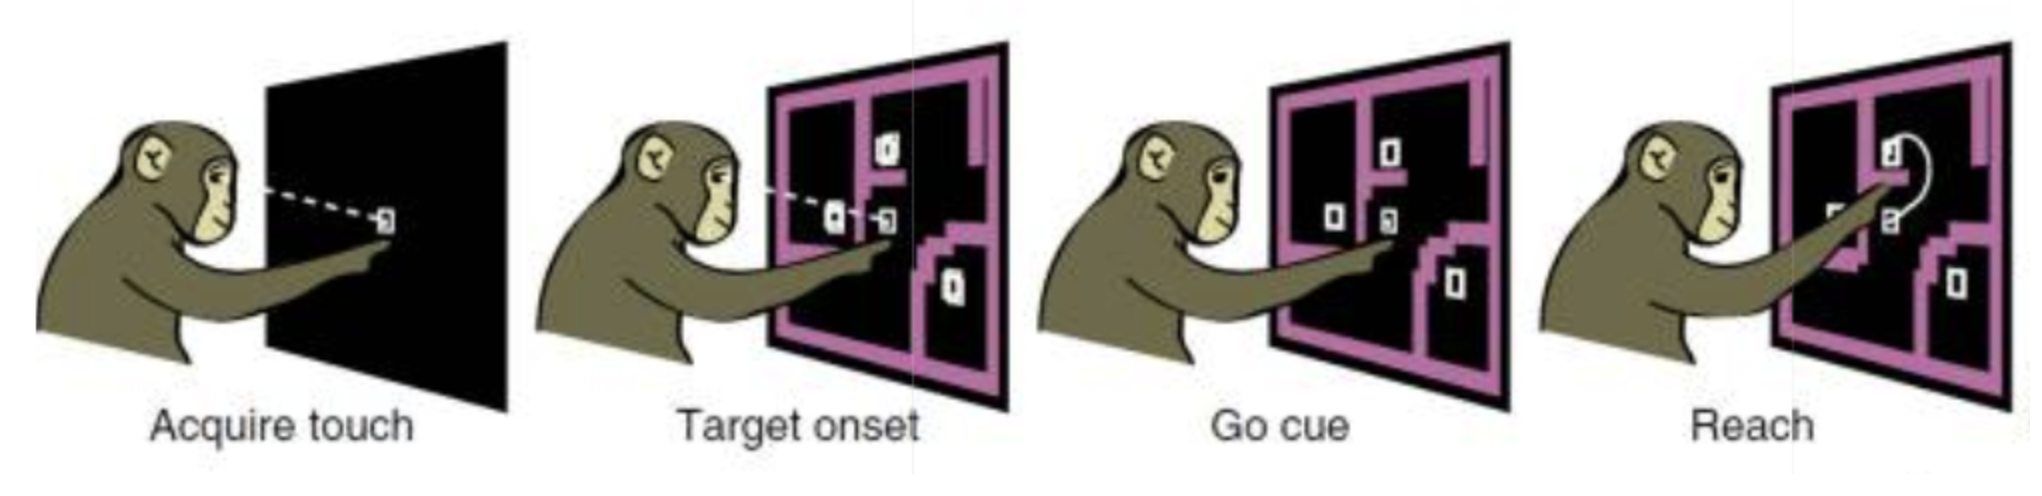

### 1.1 Task

The maze task is a delayed center-out reaching task, meaning that there was a period between target presentation and the go cue when the monkey could plan and prepare its movement. The reaches took place in a number of maze configurations, resulting in a variety of straight and curved reaches. In some trials, three targets were presented, though only one was reachable, further complicating the task for the monkey. The delayed reaching paradigm allows for the examination of neural activity during both movement preparation and execution.

### 1.2 Data

For these datasets, neural activity was recorded from two Utah arrays: one implanted in the dorsal premotor cortex, which is thought to play a role in movement planning, and one in the primary motor cortex. This recorded data was spike sorted offline into the provided unit spike times. In addition to the neural data, cursor position and the monkeys' hand and gaze position were recorded during the experiment, and we estimated the hand velocity offline using the recorded hand position.

The MC_Maze datasets are entirely trialized, and no data was recorded between trials. As a result, though the data is presented here as a single continuous block, trials are separated by NaN margins to indicate when the data is discontinuous. In addition, in three of our dataset files, we reduced the number of trials to a fixed amount for evaluation of model performance on limited data.

## 2 Exploring the data

### 2.1 Setup

First, let's make the necessary imports and load the dataset.

In [1]:
## Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
# !dandi download https://gui.dandiarchive.org/#/dandiset/000128 -o "../Datasets"

In [1]:
## Imports

# %matplotlib widget # uncomment for interactive plots
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [2]:
## Load dataset
data_dir = os.path.join("..", "Datasets", "000128", "sub-Jenkins")
dataset = NWBDataset(data_dir, "*train", split_heldout=False)

### 2.2 Continuous data

The continuous data provided with the MC_Maze datasets includes:
* `cursor_pos` - x and y position of the cursor controlled by the monkey
* `eye_pos` - x and y position of the monkey's point of gaze on the screen, in mm
* `hand_pos` - x and y position of the monkey's hand, in mm
* `hand_vel` - x and y velocities of the monkey's hand, in mm/s, computed offline using `np.gradient`
* `spikes` - spike times binned at 1 ms

In [3]:
## View 'dataset.data'
dataset.data

signal_type             cursor_pos            eye_pos           hand_pos  \
channel                          x          y       x      y           x   
clock_time                                                                 
0 days 00:00:00          -0.900000  -5.700000     7.2    2.0   -0.714908   
0 days 00:00:00.001000   -0.907457  -5.687027     7.2    2.1   -0.717532   
0 days 00:00:00.002000   -0.912768  -5.672115     7.6    1.2   -0.720323   
0 days 00:00:00.003000   -0.914050  -5.653433     7.4    1.4   -0.723278   
0 days 00:00:00.004000   -0.909980  -5.629617     7.4    3.6   -0.726362   
...                            ...        ...     ...    ...         ...   
0 days 01:55:52.296000 -114.378901 -79.712313   -95.0 -117.5 -114.334012   
0 days 01:55:52.297000 -114.366164 -79.728485   -94.9 -117.4 -114.333252   
0 days 01:55:52.298000 -114.365911 -79.749577   -94.6 -117.7 -114.332816   
0 days 01:55:52.299000 -114.378419 -79.774473   -94.8 -117.7 -114.332814   
0 days 01:55:52.300000 -114.400000 -79.800000   -97.8 -118.2 -114.333242   

signal_type                         hand_vel            spikes       ...       \
channel                          y         x          y   1011 1021  ... 2861   
clock_time                                                           ...        
0 days 00:00:00         -40.526123 -2.624567  29.977111    0.0  0.0  ...  0.0   
0 days 00:00:00.001000  -40.496146 -2.707321  30.577662    0.0  0.0  ...  0.0   
0 days 00:00:00.002000  -40.464968 -2.872729  31.744164    0.0  0.0  ...  0.0   
0 days 00:00:00.003000  -40.432658 -3.019660  32.847931    0.0  0.0  ...  0.0   
0 days 00:00:00.004000  -40.399272 -3.059403  33.895227    0.0  0.0  ...  0.0   
...                            ...       ...        ...    ...  ...  ...  ...   
0 days 01:55:52.296000 -114.809976  0.905895  -0.883716    0.0  0.0  ...  0.0   
0 days 01:55:52.297000 -114.810622  0.598148  -0.420075    0.0  0.0  ...  0.0   
0 days 01:55:52.298000 -114.810816  0.218816   0.012961    0.0  0.0  ...  0.0   
0 days 01:55:52.299000 -114.810596 -0.212940   0.393580    0.0  0.0  ...  0.0   
0 days 01:55:52.300000 -114.810029 -0.427820   0.566803    0.0  0.0  ...  0.0   

signal_type                                                          
channel                2862 2871 2881 2882 2911 2931 2941 2951 2961  
clock_time                                                           
0 days 00:00:00         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.001000  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
0 days 00:00:00.002000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.003000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.004000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  
0 days 01:55:52.296000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 01:55:52.297000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 01:55:52.298000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 01:55:52.299000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0 days 01:55:52.300000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[6952301 rows x 190 columns]

### 2.3 Trial metadata

The trial info dataframe has a number of fields containing information about each trial:
* `trial_id` - a number assigned to each trial during loading
* `start_time` - time when the trial begins
* `end_time` - time when the trial ends
* `trial_type` - the maze configuration that was used for the trial
* `trial_version` - a number 0-2 indicating which variant of the maze is presented. 0 is 1-target no-barrier, 1 is 1-target with barriers, 2 is 3-target with barriers
* `maze_id` - a unique identifier for the maze configuration used. Different maze sets were used for each session, so `trial_type` is not unique across dataset files
* `success` - whether the trial was successful. In provided training data, unsuccessful trials have already been removed
* `target_on_time` - time of target presentation
* `go_cue_time` - time of go cue
* `move_onset_time` - time of movement onset, calculated offline with robust algorithm
* `rt` - reaction time in ms
* `delay` - time between target presentation and go cue in ms
* `num_targets` - number of targets displayed in the maze
* `target_pos` - x and y position of the target(s)
* `num_barriers` - number of barriers in the maze
* `barrier_pos` - position of the barrier(s). First two values are the x and y positions of the center of the barrier, last two values are the half-width and half-height of the barrier
* `active_target` - which target is reachable and was hit by the monkey. Its value corresponds to the index of the target in `target_pos`

In [4]:
## View 'dataset.trial_info'
dataset.trial_info

,trial_id,start_time,end_time,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,move_onset_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target,split
0,0,0 days 00:00:00,0 days 00:00:03.321000,25,2,84,True,0 days 00:00:00.880000,0 days 00:00:01.478000,0 days 00:00:01.905000,427,598,3,"[[-111, -82], [-108, 81], [118, 72]]",8,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2,val
1,1,0 days 00:00:03.400000,0 days 00:00:06.521000,3,1,3,True,0 days 00:00:04.291000,0 days 00:00:04.739000,0 days 00:00:05.280000,541,448,1,"[[-116, -5]]",6,"[[-69, -16, 13, 69], [-120, -62, 83, 15], [95,...",0,val
2,2,0 days 00:00:06.600000,0 days 00:00:09.856000,22,1,66,True,0 days 00:00:07.471000,0 days 00:00:07.969000,0 days 00:00:08.346000,377,498,1,"[[-82, -86]]",9,"[[34, -41, 86, 8], [9, -42, 33, 19], [7, -41, ...",0,train
3,3,0 days 00:00:09.900000,0 days 00:00:12.946000,29,2,100,True,0 days 00:00:10.853000,0 days 00:00:11.335000,0 days 00:00:11.752000,417,482,3,"[[-109, 2], [2, 82], [132, -65]]",9,"[[-9, 52, 43, 8], [-50, 91, 14, 64], [-133, -5...",1,train
4,4,0 days 00:00:13,0 days 00:00:15.481000,21,0,65,True,0 days 00:00:13.687000,0 days 00:00:14.235000,0 days 00:00:14.507000,272,548,1,"[[27, 82]]",0,[],0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,2290,0 days 01:55:36.600000,0 days 01:55:39.796000,34,1,91,True,0 days 01:55:37.362000,0 days 01:55:38.277000,0 days 01:55:38.585000,308,915,1,"[[116, -77]]",7,"[[66, -43, 30, 9], [-66, 1, 11, 70], [-35, 50,...",0,train
2291,2291,0 days 01:55:39.900000,0 days 01:55:42.736000,15,1,75,True,0 days 01:55:40.717000,0 days 01:55:41.265000,0 days 01:55:41.641000,376,548,1,"[[133, -81]]",9,"[[-33, 47, 37, 6], [-77, 48, 61, 11], [-64, -2...",0,train
2292,2292,0 days 01:55:42.800000,0 days 01:55:45.766000,23,0,67,True,0 days 01:55:43.465000,0 days 01:55:44.396000,0 days 01:55:44.714000,318,931,1,"[[94, -86]]",0,[],0,train
2293,2293,0 days 01:55:45.800000,0 days 01:55:49.201000,25,2,84,True,0 days 01:55:46.631000,0 days 01:55:46.663000,0 days 01:55:47.616000,953,32,3,"[[-111, -82], [-108, 81], [118, 72]]",8,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2,val


### 2.4 Reach conditions

The full MC_Maze dataset has 108 different reach conditions, and the reduced-size datasets each have 27. Because of the maze barriers, reaches take on a variety of straight and curved trajectories. Here, we'll plot the average trajectory per condition to see what typical reaches look like.

In [5]:
## Optional resampling
# It may be beneficial to resample the data before you proceed to the analysis sections,
# as they may be fairly memory-intensive. However, we have not tested this notebook at bin sizes
# of over 20 ms, so we cannot guarantee that everything will work as intended at
# those larger bin sizes. If you still have memory issues, you could also use the reduced size
# datasets instead of the full one.
dataset.resample(5)

108


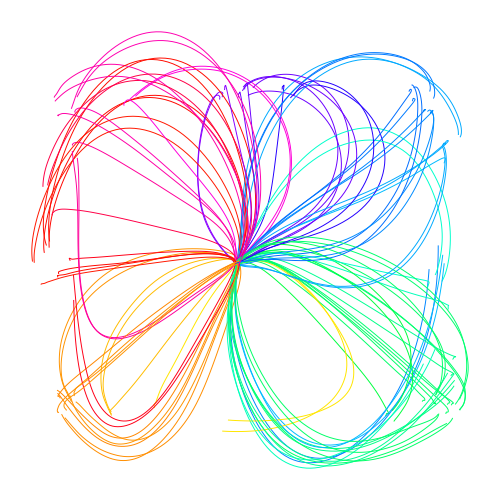

In [6]:
## Plot trial-averaged reaches

# Find unique conditions
conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()

# Initialize plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond in conds:
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Extract trial data
    trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450), ignored_trials=(~mask))
    # Average hand position across trials
    traj = trial_data.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle = np.arctan2(*active_target[::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))

plt.axis('off')
plt.show()

### 2.5 Single-neuron responses

As shown above, there are a large number of conditions in the full MC_Maze dataset which differ in the position and number of targets and barriers. While many of the reaches follow similar trajectories, the differences in the exact positions of targets and barriers may result in slight differences in observed neural activity, especially during pre-movement planning periods. Here, we'll plot PSTHs for a single neuron for a subset of the conditions.

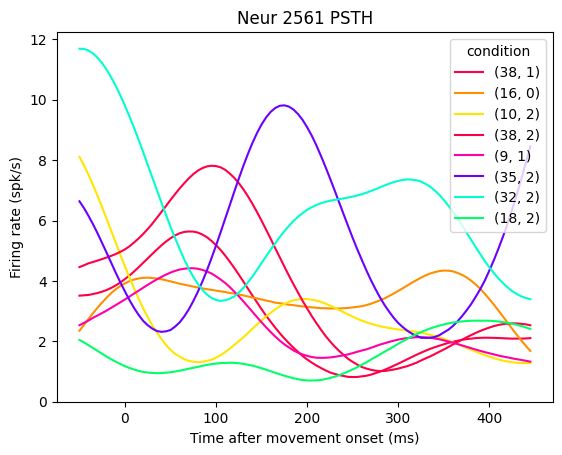

In [7]:
## Plot PSTHs

# Seed generator for consistent plots
np.random.seed(2468)
n_conds = 8 # number of conditions to plot

# Smooth spikes with 50 ms std Gaussian
dataset.smooth_spk(50, name='smth_50')

# Plot random neuron
neur_num = np.random.choice(dataset.data.spikes.columns)

# Find unique conditions
conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()

# Plot random subset of conditions
for i in np.random.choice(len(conds), size=n_conds, replace=False):
    cond = conds[i]
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Extract trial data
    trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450), ignored_trials=(~mask))
    # Average hand position across trials
    psth = trial_data.groupby('align_time')[[('spikes_smth_50', neur_num)]].mean().to_numpy() / dataset.bin_width * 1000
    # Color PSTHs by reach angle
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle = np.arctan2(*active_target[::-1])
    # Plot reach
    plt.plot(np.arange(-50, 450, dataset.bin_width), psth, label=cond, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))

# Add labels
plt.ylim(bottom=0)
plt.xlabel('Time after movement onset (ms)')
plt.ylabel('Firing rate (spk/s)')
plt.title(f'Neur {neur_num} PSTH')
plt.legend(title='condition', loc='upper right')
plt.show()

As you can see,  this neuron displays a variety of responses in different conditions. However, the information provided by this individual neuron is limited, and this method relies on averaging across trials, which discards single-trial variablity as noise. Instead of averaging across trials, we can use the activity of the whole neural population on a single-trial basis to extract behaviorally-relevant information.

### 2.6 Decoding hand kinematics

Next, we'll try to decode the monkey's hand velocity solely from smoothed population spiking activity. Since it takes time for signals to travel from the motor cortex to muscles, we lag the kinematics data relative to neural data. 80 ms lag is where we have seen the best results, but feel free to vary the value and compare performance.

In [8]:
## Kinematic decoding

# Extract neural data and lagged hand velocity
trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-130, 370))
lagged_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450))
rates = trial_data.spikes_smth_50.to_numpy()
vel = lagged_trial_data.hand_vel.to_numpy()

# Fit and evaluate decoder
gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
gscv.fit(rates, vel)
pred_vel = gscv.predict(rates)
print(f"Decoding R2: {gscv.best_score_}")

# Merge predictions back to continuous data
pred_vel_df = pd.DataFrame(pred_vel, index=lagged_trial_data.clock_time, columns=pd.MultiIndex.from_tuples([('pred_vel', 'x'), ('pred_vel', 'y')]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)

Decoding R2: 0.648265211599087


We got an R2 of around 0.6, which is not too bad. Let's visualize how our predicted kinematics compare to the true data. We'll plot results for only one condition to keep things from getting too cluttered.

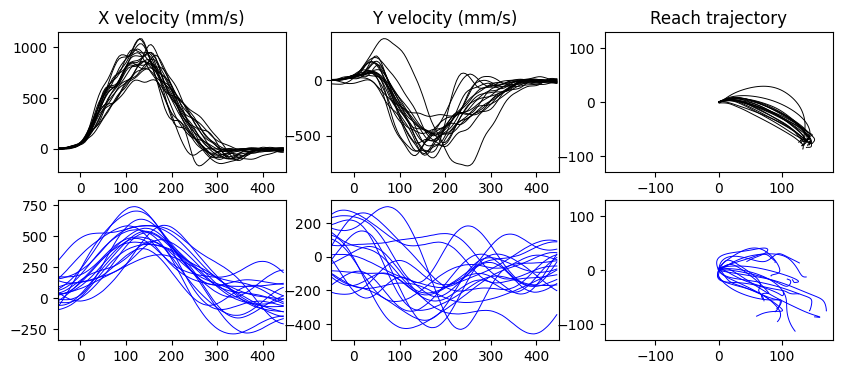

In [10]:
## Plot predicted vs true kinematics

# Choose 23rd condition to plot
cond = conds[23]

# Find trials in condition and extract data
mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450), ignored_trials=(~mask))

# Initialize figure
fig, axs = plt.subplots(2, 3, figsize=(10, 4))
t = np.arange(-50, 450, dataset.bin_width)

# Loop through trials in condition
for _, trial in trial_data.groupby('trial_id'):
    # True and predicted x velocity
    axs[0][0].plot(t, trial.hand_vel.x, linewidth=0.7, color='black')
    axs[1][0].plot(t, trial.pred_vel.x, linewidth=0.7, color='blue')
    # True and predicted y velocity
    axs[0][1].plot(t, trial.hand_vel.y, linewidth=0.7, color='black')
    axs[1][1].plot(t, trial.pred_vel.y, linewidth=0.7, color='blue')
    # True and predicted trajectories
    true_traj = np.cumsum(trial.hand_vel.to_numpy(), axis=0) * dataset.bin_width / 1000
    pred_traj = np.cumsum(trial.pred_vel.to_numpy(), axis=0) * dataset.bin_width / 1000
    axs[0][2].plot(true_traj[:, 0], true_traj[:, 1], linewidth=0.7, color='black')
    axs[1][2].plot(pred_traj[:, 0], pred_traj[:, 1], linewidth=0.7, color='blue')

# Set up shared axes
for i in range(2):
    axs[i][0].set_xlim(-50, 450)
    axs[i][1].set_xlim(-50, 450)
    axs[i][2].set_xlim(-180, 180)
    axs[i][2].set_ylim(-130, 130)

# Add labels
axs[0][0].set_title('X velocity (mm/s)')
axs[0][1].set_title('Y velocity (mm/s)')
axs[0][2].set_title('Reach trajectory')
plt.show()

As you can see, decoding from single-trial smoothed spikes is able to recover general trends in hand kinematics but cannot accurately recover the true kinematics very well, particularly in the y-direction.

### 2.7 Neural trajectories

Finally, we'll look at how neural population activity evolves over time in each condition by applying PCA to trial-averaged smoothed spikes. We'll plot the resulting trajectories and compare them across conditions.

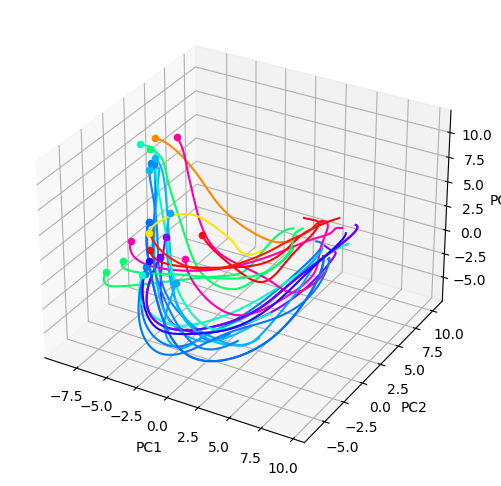

In [11]:
## Plot neural trajectories for subset of conditions

# Seed generator for consistent plots
np.random.seed(2021)
n_conds = 27 # number of conditions to plot

# Get unique conditions
conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()

# Loop through conditions
rates = []
colors = []
for i in np.random.choice(len(conds), n_conds):
    cond = conds[i]
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Extract trial data
    trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450), ignored_trials=(~mask))
    # Append averaged smoothed spikes for condition
    rates.append(trial_data.groupby('align_time')[trial_data[['spikes_smth_50']].columns].mean().to_numpy())
    # Append reach angle-based color for condition
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle = np.arctan2(*active_target[::-1])
    colors.append(plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))

# Stack data and apply PCA
rate_stack = np.vstack(rates)
rate_scaled = StandardScaler().fit_transform(rate_stack)
pca = PCA(n_components=3)
traj_stack = pca.fit_transform(rate_scaled)
traj_arr = traj_stack.reshape((n_conds, len(rates[0]), -1))

# Loop through trajectories and plot
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for traj, col in zip(traj_arr, colors):
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=col)
    ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], color=col)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

You might see that conditions with similar reach angles tend to be clustered together. Note that coloring by angle to the target does not take into account the curved paths of the reaches toward the target, so you should not expect all similarly colored conditions to have similar neural trajectories.

Using an alternate dimensionality reduction method called jPCA, researchers have revealed rotational dynamics in neural population activity during these maze reaches. You can read more about that in this [paper](https://www.nature.com/articles/nature11129).

## 3 Summary

In this notebook, we:
* introduced the MC_Maze dataset, describing the task and provided data
* looked at what specific continuous and trial data is included
* demonstrated the task by plotting average reach trajectories for each condition
* explored single-neuron responses by plotting PSTHs for some conditions
* evaluated how accurately spike-smoothed population activity can decode hand velocity
* visualized the timecourse of neural population activity by extracting trial-averaged neural trajectories with PCA

The Maze datasets are exceptional in their combination of behavioral richness (number of task configurations), stereotyped behavior across repeated trials (tens of repeats for each task configuration), and high total trial counts (thousands). Due to the instructed delay paradigm and lack of unpredictable task events, population activity can be well-modeled as an autonomous dynamical system. Because of this, the dataset has been used for validating a number of latent variable models.